# Tree-based algorithms (Hyperparameter Tuning)

> A tutorial showing how to tune the hyperparameters of the Tree-based algorithms.

- toc: true 
- badges: true
- comments: true
- categories: [Tree-based algorithms, hyperparameter, tuning, machine learning, Decision Tree Classifier, Random Forest Classifier, Gradient Boosting Classifier, Extreme Gradient Boosting Classifier, Light Gradient Boosting Classifier, Categorical Booting Classifier, Feature Importance, Tree-based Algorithm Visualizations, Overfitting Reduction, Xgboost, LightGBM, Catboost]
- image: images/tree_based_algorithms.png

## 1) Import libraries and define functions

### 1.1) Install libraries

In [ ]:
!pip install dtreeviz &> /dev/null
!pip install catboost &> /dev/null

### 1.2) Import Libraries

In [ ]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from subprocess import call
from termcolor import colored
import matplotlib.pyplot as plt
from itertools import chain,cycle
from sklearn import tree, metrics
from xgboost import XGBClassifier
from dtreeviz.trees import dtreeviz
from catboost import CatBoostClassifier
from yellowbrick.contrib.wrapper import wrap
from IPython.display import Image, display, HTML, display_html
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from yellowbrick.classifier import ROCAUC, ConfusionMatrix, ClassificationReport
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier

sns.set_theme()
warnings.filterwarnings("ignore")
plt.rcParams['font.family'] = 'DeJavu Serif'

## 2) Exploratory Data Analysis (EDA)

For the sake of this tutorial, we will not engage in extensive EDA. However, the visualization posts bring very detailed EDA analyses.

### 2.1) Load File

In [ ]:
file_name_1 = 'https://raw.githubusercontent.com/leonardodecastro/data/main/heart.csv'

data = pd.read_csv(file_name_1,header=None, names=(['A','S', 'TCP', 'RBP', 'C', 'BS', 'REE', 'MHRA', 'EIA',  'DIE',  'SPE', 'NMV', 'T', 'HD']))
data.head(2)

,A,S,TCP,RBP,C,BS,REE,MHRA,EIA,DIE,SPE,NMV,T,HD
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1


A = 'Age'     S = 'Sex'      TCP = 'Type of chest pain'     RBP = 'Resting blood pressure'     C = 'Cholesterol'      BS = 'Blood sugar'     REE = 'Resting electrocardiographic results'     MHRA =  'Maximum heart rate achieved'     EIA = 'Exercise induced angina'    DIE =  'ST depression induced by exercise'     SPE = 'Slope of the peak exercise ST segment'     NMV = 'Number of major vessels colored by flourosopy'     T = 'Thalassemia'     HD = 'Heart Disease?'

## 3) Split and scale data

- Classification trees do not require normalization since this is a type of tree-based algorithm which relies on rules. This means that classification trees are not affected by monotonic transformations of the input features.

- On the other hand, if we were to use error based algorithms such as logistic and linear regression or even neural networkds, the convergence to the global minimum would be faster if the variables were scaled. 

In [ ]:
# This line will disappear in the portfolio page
# Determine which variables are the features and which variable is the target
X = data.drop(['HD'],axis=1)
y = data[ 'HD']

#  Split the dataframe into the training set and the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

## 4) Hyperparameter tuning (random search + cross validation)

- We seek to optimize recall to **minimize the number of false negatives** (failing to diagnose heart disease is a dire outcome). 
- We use **early stopping** to prevent overfitting and speed up model training for the **XGboost, LightGBM and CatBoost** classifiers. 

### 4.1) Decision Tree Classifier (Pruned)

We use the max-depth argument to prune the tree.

In [ ]:
# This line will disappear in the portfolio page
# Step 1: Select the classifier
clf = DecisionTreeClassifier()

# Step 2: Select possible hyperparameters to be tested
parameters = {"splitter":["best","random"], "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10], "criterion" :["gini", "entropy", "log_loss"], "random_state" : [42],
                "min_weight_fraction_leaf":[0, 0.1,0.2,0.3,0.4,0.5],"min_impurity_decrease": [0.0] ,"class_weight":[None,'balanced'],
                "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90], 'min_samples_split': [1,2,3,4,5,6,7,8,9,10], "ccp_alpha": [0],"max_depth" : [2,3,4,5,6,7]}

# Step 3: Determine the optimal hyperparameters to maximize the recall metrics
grid = RandomizedSearchCV(estimator = clf, param_distributions = parameters, scoring = 'recall', cv = 5, n_iter = 500, random_state=42)
grid.fit(X_train, y_train.ravel()) # We need to use .values.ravel() to avoid warning message
best_parameters_model_1 = grid.best_params_
print('Optimal hyperparameters: \n\n',best_parameters_model_1)

Optimal hyperparameters: 

 {'splitter': 'random', 'random_state': 42, 'min_weight_fraction_leaf': 0, 'min_samples_split': 4, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 80, 'max_depth': 6, 'criterion': 'entropy', 'class_weight': 'balanced', 'ccp_alpha': 0}


Find detailed information on each hyperparameter of decision tree classifiers on the following website:

https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3

### 4.2) Random Forest Classifier

In [ ]:
# This line will disappear in the portfolio page
# Step 1: Select the classifier
clf = RandomForestClassifier()

# Step 2: Select possible hyperparameters to be tested
parameters = {"n_estimators" : [100, 200, 300, 400, 500], "criterion" :["gini", "entropy", "log_loss"],
                "max_depth" : [2,3,4,5,6,7],'min_samples_split': [1,2,3,4,5,6,7,8,9,10], "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],"ccp_alpha": [0],
                "class_weight":[None,'balanced'], "min_weight_fraction_leaf":[0, 0.1,0.2,0.3,0.4,0.5],  "max_features" : ['auto', 'sqrt'],
                "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90], "min_impurity_decrease": [0.0], "random_state":[42]}

# Step 3: Determine the optimal hyperparameters to maximize the recall metrics
grid = RandomizedSearchCV(estimator = clf, param_distributions = parameters, scoring = 'recall', cv = 5, n_iter = 500, random_state=42)
grid.fit(X_train, y_train.ravel()) # We need to use .values.ravel() to avoid warning message
best_parameters_model_2 = grid.best_params_
print('Optimal hyperparameters: \n\n',best_parameters_model_2)

Optimal hyperparameters: 

 {'random_state': 42, 'n_estimators': 200, 'min_weight_fraction_leaf': 0.3, 'min_samples_split': 4, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 30, 'max_features': 'auto', 'max_depth': 4, 'criterion': 'entropy', 'class_weight': 'balanced', 'ccp_alpha': 0}


### 4.3) Gradient Boosting Classifier

In [ ]:
# This line will disappear in the portfolio page
# Step 1: Select the classifier
clf = GradientBoostingClassifier()

# Step 2: Select possible hyperparameters to be tested
parameters = {"n_estimators" : [100, 200, 300, 400, 500], "criterion" :["friedman_mse", "squared_error", "mse"], "loss":['log_loss', 'deviance', 'exponential'],
                "max_depth" : [2,3,4,5,6,7],'min_samples_split': [1,2,3,4,5,6,7,8,9,10], "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],"ccp_alpha": [0],
                "min_weight_fraction_leaf":[0, 0.1,0.2,0.3,0.4,0.5],  "max_features" : ['auto', 'sqrt'],'learning_rate':[0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
                "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90], "min_impurity_decrease": [0.0],"random_state":[42],'subsample' : [0.4,0.5,0.6,0.7,0.8,1.0]}

# Step 3: Determine the optimal hyperparameters to maximize the recall metrics
grid = RandomizedSearchCV(estimator = clf, param_distributions = parameters, scoring = 'recall', cv = 5, n_iter = 500, random_state=42)
grid.fit(X_train, y_train.ravel()) # We need to use .values.ravel() to avoid warning message
best_parameters_model_3 = grid.best_params_
print('Optimal hyperparameters: \n\n',best_parameters_model_3)

Optimal hyperparameters: 

 {'subsample': 0.4, 'random_state': 42, 'n_estimators': 200, 'min_weight_fraction_leaf': 0.4, 'min_samples_split': 8, 'min_samples_leaf': 8, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 40, 'max_features': 'sqrt', 'max_depth': 6, 'loss': 'deviance', 'learning_rate': 0.15, 'criterion': 'mse', 'ccp_alpha': 0}


### 4.4) Extreme Gradient Boosting Classifier

In [ ]:
# This line will disappear in the portfolio page
# Step 1: Select the classifier
clf = XGBClassifier()

# Step 2: Select possible hyperparameters to be tested
parameters = {"n_estimators" : [i for i in range(100,1000,100)], "max_depth" : [2,3,4,5,6,7], 'learning_rate':[0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
                "random_state":[42], 'min_child_weight': [1,2,3,4,5,6,7], 'subsample':[i/10.0 for i in range(1,10)], 'early_stopping_rounds':[5], 
                'gamma':[0.01, 0.05, 0.1, 0.15, 0.2, 0.3], 'colsample_bytree':[i/10.0 for i in range(1,10)],
                'reg_lambda' : [0, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3]}

# Step 3: Determine the optimal hyperparameters to maximize the recall metrics
grid = RandomizedSearchCV(estimator = clf, param_distributions = parameters, scoring = 'recall', cv = 5, n_iter = 500, random_state=42)
grid.fit(X_train, y_train.ravel()) # We need to use .values.ravel() to avoid warning message
best_parameters_model_4 = grid.best_params_
print('Optimal hyperparameters: \n\n',best_parameters_model_4)

Optimal hyperparameters: 

 {'subsample': 0.3, 'reg_lambda': 0.3, 'random_state': 42, 'n_estimators': 900, 'min_child_weight': 4, 'max_depth': 4, 'learning_rate': 0.15, 'gamma': 0.2, 'early_stopping_rounds': 5, 'colsample_bytree': 0.4}


More information on the hyperparameters for xgboost at the following page:
https://xgboost.readthedocs.io/en/stable/python/python_api.html

In [ ]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

### 4.5) Light Gradient Boosting Classifier

In [ ]:
# This line will disappear in the portfolio page
# Step 1: Select the classifier
clf = lgb.LGBMClassifier()

# Step 2: Select possible hyperparameters to be tested
parameters = {"n_estimators" : [i for i in range(100,1000,100)], "max_depth" : [2,3,4,5,6,7], 'learning_rate':[0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
              'num_leaves' : [i for i in range(10,200,10)], 'lambda_l2':[0, 0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 1, 5, 10],
              "random_state":[42], 'subsample':[i/10.0 for i in range(1,10)], 'feature_fraction':[i/10.0 for i in range(1,10)], 'early_stopping_round' : [5],
              'bagging_fraction' :[i/10.0 for i in range(1,10)], 'bagging_freq': [i for i in range(1,10)], 'min_child_samples' : [i for i in range(1,100)],
              'min_data_in_leaf': [i for i in range(20,200,10)], 'lambda_l1' : [0, 0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 1, 5, 10]}

# Step 3: Determine the optimal hyperparameters to maximize the recall metrics
grid = RandomizedSearchCV(estimator = clf, param_distributions = parameters, scoring = 'recall', cv = 5, n_iter = 500, random_state=42)
grid.fit(X_train, y_train.ravel(), eval_set = (X_train, y_train), verbose=0) # We need to use .values.ravel() to avoid warning message
best_parameters_model_5 = grid.best_params_
print('Optimal hyperparameters: \n\n',best_parameters_model_5)

Optimal hyperparameters: 

 {'subsample': 0.8, 'random_state': 42, 'num_leaves': 160, 'n_estimators': 800, 'min_data_in_leaf': 20, 'min_child_samples': 12, 'max_depth': 3, 'learning_rate': 0.3, 'lambda_l2': 0.05, 'lambda_l1': 0.05, 'feature_fraction': 0.3, 'early_stopping_round': 5, 'bagging_freq': 2, 'bagging_fraction': 0.3}


The following pages provide good sources to read about how to prevent ovefitting using Light Gradient Boosting Classifier:
- https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5
- https://practicaldatascience.co.uk/machine-learning/how-to-tune-a-lightgbmclassifier-model-with-optuna


### 4.6) Categorical Booting Classifier

In [ ]:
# This line will disappear in the portfolio page
# Step 1: Select the classifier
clf = CatBoostClassifier()

# Step 2: Select possible hyperparameters to be tested
parameters = {'depth':[2,3,4,5,6,7], 'n_estimators':[i for i in range(100,1000,100)], 'subsample': [i/10 for i in range(0,10)],
              'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3], 'num_leaves': [i for i in range(16,40,2)],
              'max_bin':[i for i in range(150,300,10)], 'l2_leaf_reg' : list(10.0**(np.arange(-8, 2))),
              'model_size_reg': list(np.linspace(0, 10, 50)), 'early_stopping_rounds':[5], 
              'bagging_temperature':[i for i in range(0,10)],'random_strength': list(np.linspace(0, 10, 50))}

# Step 3: Determine the optimal hyperparameters to maximize the recall metrics
grid = RandomizedSearchCV(estimator = clf, param_distributions = parameters, scoring = 'recall', cv = 5, n_iter = 500, random_state=42)
grid.fit(X_train, y_train.ravel(), eval_set = (X_train, y_train), verbose=0) # We need to use .values.ravel() to avoid warning message
best_parameters_model_6 = grid.best_params_
print('Optimal hyperparameters: \n\n',best_parameters_model_6)

Optimal hyperparameters: 

 {'subsample': 0.3, 'random_strength': 2.6530612244897958, 'num_leaves': 16, 'n_estimators': 400, 'model_size_reg': 5.714285714285714, 'max_bin': 160, 'learning_rate': 0.01, 'l2_leaf_reg': 0.1, 'early_stopping_rounds': 5, 'depth': 4, 'bagging_temperature': 8}


The following pages provide good sources to read about how to prevent ovefitting using Light Gradient Boosting Classifier:
- https://docs.aws.amazon.com/sagemaker/latest/dg/catboost-tuning.html
- https://effectiveml.com/using-grid-search-to-optimise-catboost-parameters.html
- https://www.kaggle.com/code/saurabhshahane/catboost-hyperparameter-tuning-with-optuna
- https://www.kaggle.com/code/shivampanwar/catboost-and-hyperparameter-tuning-using-bayes

## 5) Evaluation of optimal model metrics

### 5.1) Classif. Report, ROC Curve and Confusion Matrix (Decision Tree - Pruned)

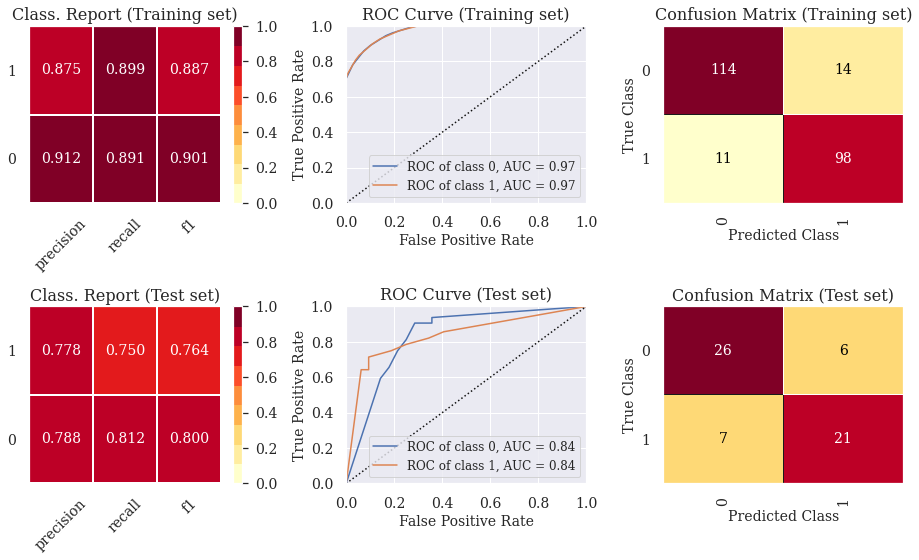

In [ ]:
# This line will disappear in the portfolio page
# Step 1: Set the size of the figure
plt.rcParams.update({'font.size': 14,'axes.titlesize': 16,'axes.labelsize': 14,'xtick.labelsize': 14,'ytick.labelsize': 14, 'legend.fontsize': 12})
fig, axes = plt.subplots(2,3, figsize=(13, 8))

# Step 2: Select the classifier
model = DecisionTreeClassifier(**best_parameters_model_1)

# Step 3: Create lists with the visualizers
visualizers_list_training = [ClassificationReport(model, classes=[0, 1], ax=axes[0,0], title = "Class. Report (Training set)"),
                    ROCAUC(model, classes=[0, 1], ax=axes[0,1], title = "ROC Curve (Training set)",micro=False, macro=False),
                    ConfusionMatrix(model, classes=[0, 1], ax=axes[0,2], title = "Confusion Matrix (Training set)")]

visualizers_list_test = [ClassificationReport(model, classes=[0, 1], ax=axes[1,0], title = "Class. Report (Test set)"),
                    ROCAUC(model, classes=[0, 1], ax=axes[1,1], title = "ROC Curve (Test set)",micro=False, macro=False),
                    ConfusionMatrix(model, classes=[0, 1], ax=axes[1,2], title = "Confusion Matrix (Test set)")]

# Step 4: Generate visualizations for the training set
for visualizer in visualizers_list_training:
  visualizer.fit(X_train, y_train)                                # Fit the training data to the visualizer
  visualizer.score(X_train, y_train)                              # Evaluate the model on the training data
  visualizer.finalize()

# Step 5: Generate visualizations for the test set
for visualizer in visualizers_list_test:
  visualizer.fit(X_train, y_train)                                # Fit the training data to the visualizer
  visualizer.score(X_test, y_test)                              # Evaluate the model on the test data
  visualizer.finalize()

### 5.2) Classif. Report, ROC Curve and Confusion Matrix (Random Forest Classifier)

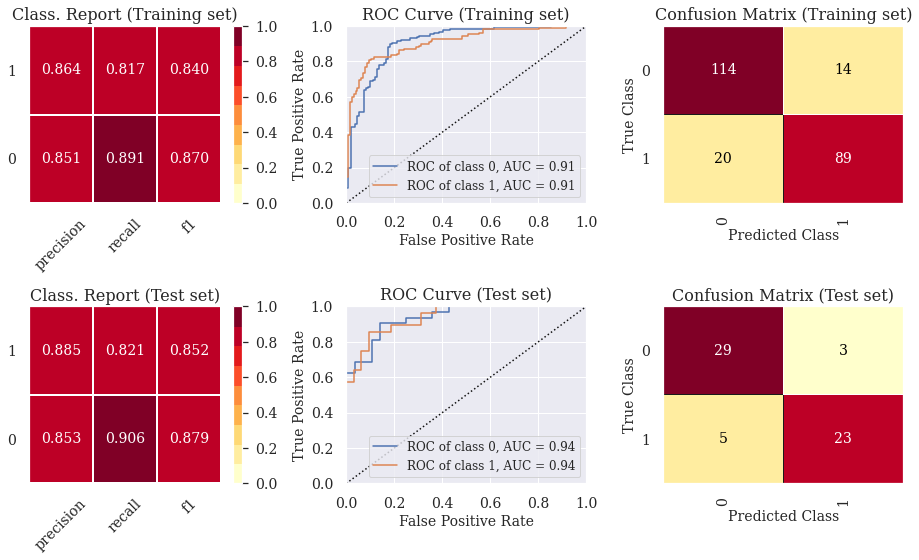

In [ ]:
# This line will disappear in the portfolio page
# Step 1: Set the size of the figure
plt.rcParams.update({'font.size': 14,'axes.titlesize': 16,'axes.labelsize': 14,'xtick.labelsize': 14,'ytick.labelsize': 14, 'legend.fontsize': 12})
fig, axes = plt.subplots(2,3, figsize=(13, 8))

# Step 2: Select the classifier
model = RandomForestClassifier(**best_parameters_model_2)

# Step 3: Create lists with the visualizers
visualizers_list_training = [ClassificationReport(model, classes=[0, 1], ax=axes[0,0], title = "Class. Report (Training set)"),
                    ROCAUC(model, classes=[0, 1], ax=axes[0,1], title = "ROC Curve (Training set)",micro=False, macro=False),
                    ConfusionMatrix(model, classes=[0, 1], ax=axes[0,2], title = "Confusion Matrix (Training set)")]

visualizers_list_test = [ClassificationReport(model, classes=[0, 1], ax=axes[1,0], title = "Class. Report (Test set)"),
                    ROCAUC(model, classes=[0, 1], ax=axes[1,1], title = "ROC Curve (Test set)",micro=False, macro=False),
                    ConfusionMatrix(model, classes=[0, 1], ax=axes[1,2], title = "Confusion Matrix (Test set)")]

# Step 4: Generate visualizations for the training set
for visualizer in visualizers_list_training:
  visualizer.fit(X_train, y_train)                                # Fit the training data to the visualizer
  visualizer.score(X_train, y_train)                              # Evaluate the model on the training data
  visualizer.finalize()

# Step 5: Generate visualizations for the test set
for visualizer in visualizers_list_test:
  visualizer.fit(X_train, y_train)                                # Fit the training data to the visualizer
  visualizer.score(X_test, y_test)                              # Evaluate the model on the test data
  visualizer.finalize()

### 5.3) Classif. Report, ROC Curve and Confusion Matrix (Gradient Boosting Classifier)

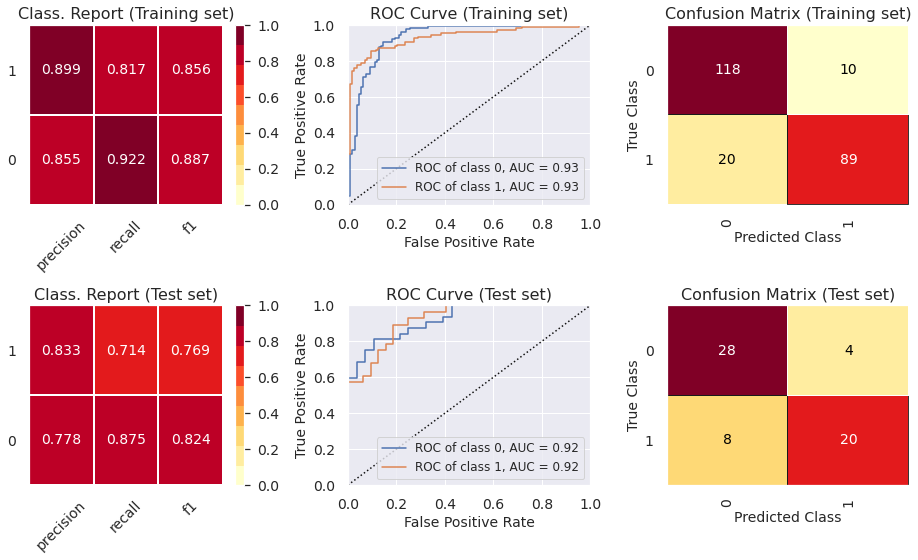

In [ ]:
# This line will disappear in the portfolio page
# Step 1: Set the size of the figure
plt.rcParams.update({'font.size': 14,'axes.titlesize': 16,'axes.labelsize': 14,'xtick.labelsize': 14,'ytick.labelsize': 14, 'legend.fontsize': 12})
fig, axes = plt.subplots(2,3, figsize=(13, 8))

# Step 2: Select the classifier (We need to fit it beforehand so that the visualizations work later on)
model = GradientBoostingClassifier(**best_parameters_model_3)

# Step 3: Create lists with the visualizers
visualizers_list_training = [ClassificationReport(model, classes=[0, 1], ax=axes[0,0], title = "Class. Report (Training set)"),
                    ROCAUC(model, classes=[0, 1], ax=axes[0,1], title = "ROC Curve (Training set)",micro=False, macro=False),
                    ConfusionMatrix(model, classes=[0, 1], ax=axes[0,2], title = "Confusion Matrix (Training set)")]

visualizers_list_test = [ClassificationReport(model, classes=[0, 1], ax=axes[1,0], title = "Class. Report (Test set)"),
                    ROCAUC(model, classes=[0, 1], ax=axes[1,1], title = "ROC Curve (Test set)",micro=False, macro=False),
                    ConfusionMatrix(model, classes=[0, 1], ax=axes[1,2], title = "Confusion Matrix (Test set)")]

# Step 4: Generate visualizations for the training set
for visualizer in visualizers_list_training:
  visualizer.fit(X_train, y_train)                                # Fit the training data to the visualizer
  visualizer.score(X_train, y_train)                              # Evaluate the model on the training data
  visualizer.finalize()

# Step 5: Generate visualizations for the test set
for visualizer in visualizers_list_test:
  visualizer.fit(X_train, y_train)                                # Fit the training data to the visualizer
  visualizer.score(X_test, y_test)                              # Evaluate the model on the test data
  visualizer.finalize()

### 5.4) Classif. Report, ROC Curve and Confusion Matrix (Extreme Gradient Boosting Classifier)

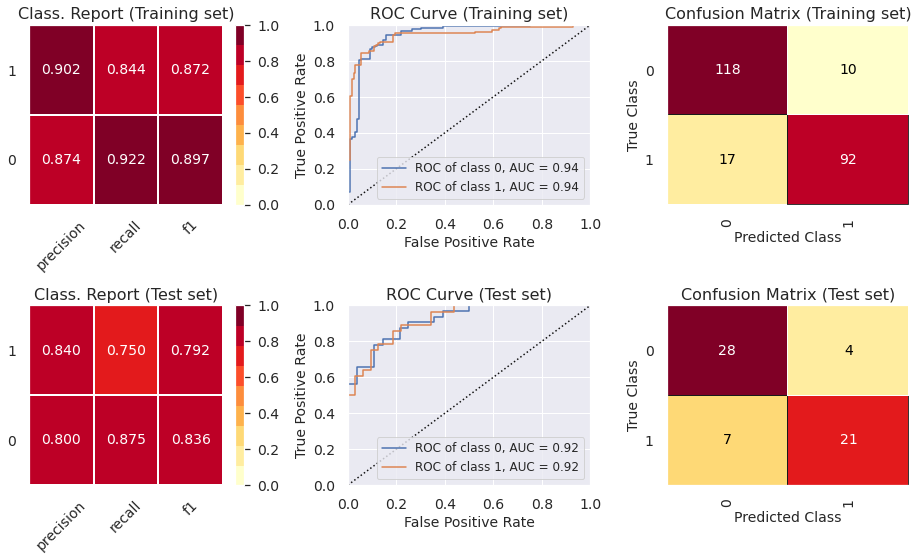

In [ ]:
# This line will disappear in the portfolio page
# Step 1: Set the size of the figure
plt.rcParams.update({'font.size': 14,'axes.titlesize': 16,'axes.labelsize': 14,'xtick.labelsize': 14,'ytick.labelsize': 14, 'legend.fontsize': 12})
fig, axes = plt.subplots(2,3, figsize=(13, 8))

# Step 2: Select the classifier (We need to fit it beforehand so that the visualizations work later on)
model = wrap(XGBClassifier(**best_parameters_model_4))
model.fit(X_train, y_train)

# Step 3: Create lists with the visualizers
visualizers_list_training = [ClassificationReport(model, classes=[0, 1], ax=axes[0,0], title = "Class. Report (Training set)"),
                    ROCAUC(model, classes=[0, 1], ax=axes[0,1], title = "ROC Curve (Training set)",micro=False, macro=False),
                    ConfusionMatrix(model, classes=[0, 1], ax=axes[0,2], title = "Confusion Matrix (Training set)")]

visualizers_list_test = [ClassificationReport(model, classes=[0, 1], ax=axes[1,0], title = "Class. Report (Test set)"),
                    ROCAUC(model, classes=[0, 1], ax=axes[1,1], title = "ROC Curve (Test set)",micro=False, macro=False),
                    ConfusionMatrix(model, classes=[0, 1], ax=axes[1,2], title = "Confusion Matrix (Test set)")]

# Step 4: Generate visualizations for the training set
for visualizer in visualizers_list_training:
  visualizer.fit(X_train, y_train)                                # Fit the training data to the visualizer
  visualizer.score(X_train, y_train)                              # Evaluate the model on the training data
  visualizer.finalize()

# Step 5: Generate visualizations for the test set
for visualizer in visualizers_list_test:
  visualizer.fit(X_train, y_train)                                # Fit the training data to the visualizer
  visualizer.score(X_test, y_test)                              # Evaluate the model on the test data
  visualizer.finalize()

### 5.5) Classif. Report, ROC Curve and Confusion Matrix (Light Gradient Boosting Classifier)

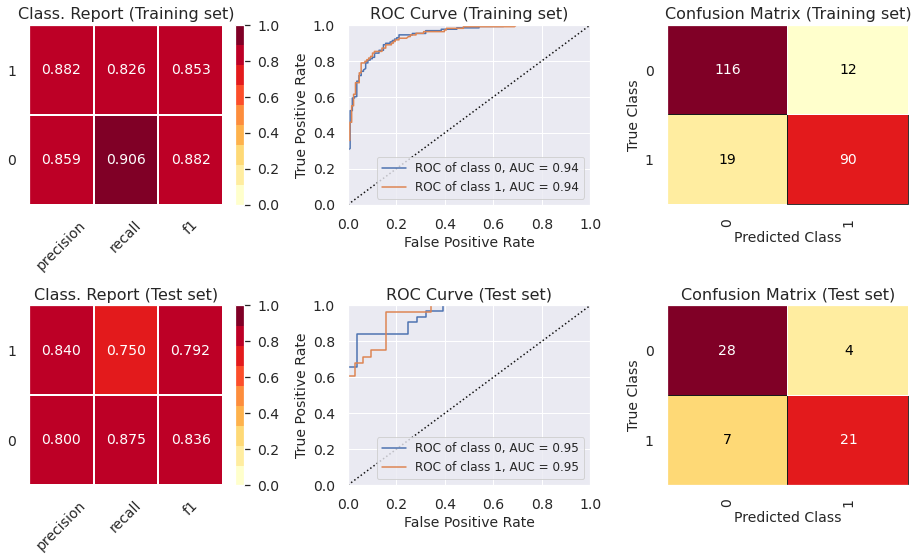

In [ ]:
# This line will disappear in the portfolio page
# Step 1: Set the size of the figure
plt.rcParams.update({'font.size': 14,'axes.titlesize': 16,'axes.labelsize': 14,'xtick.labelsize': 14,'ytick.labelsize': 14, 'legend.fontsize': 12})
fig, axes = plt.subplots(2,3, figsize=(13, 8))

# Step 2: Select the classifier (We need to fit it beforehand so that the visualizations work later on)
model = wrap(lgb.LGBMClassifier(**best_parameters_model_5))
model.fit(X_train, y_train, eval_set = (X_train, y_train), verbose=0)

# Step 3: Create lists with the visualizers
visualizers_list_training = [ClassificationReport(model, classes=[0, 1], ax=axes[0,0], title = "Class. Report (Training set)"),
                    ROCAUC(model, classes=[0, 1], ax=axes[0,1], title = "ROC Curve (Training set)",micro=False, macro=False),
                    ConfusionMatrix(model, classes=[0, 1], ax=axes[0,2], title = "Confusion Matrix (Training set)")]

visualizers_list_test = [ClassificationReport(model, classes=[0, 1], ax=axes[1,0], title = "Class. Report (Test set)"),
                    ROCAUC(model, classes=[0, 1], ax=axes[1,1], title = "ROC Curve (Test set)",micro=False, macro=False),
                    ConfusionMatrix(model, classes=[0, 1], ax=axes[1,2], title = "Confusion Matrix (Test set)")]

# Step 4: Generate visualizations for the training set
for visualizer in visualizers_list_training:
  visualizer.fit(X_train, y_train)                                # Fit the training data to the visualizer
  visualizer.score(X_train, y_train)                              # Evaluate the model on the training data
  visualizer.finalize()

# Step 5: Generate visualizations for the test set
for visualizer in visualizers_list_test:
  visualizer.fit(X_train, y_train)                                # Fit the training data to the visualizer
  visualizer.score(X_test, y_test)                              # Evaluate the model on the test data
  visualizer.finalize()

### 5.6) Classif. Report, ROC Curve and Confusion Matrix (Categorical Boosting Classifier)

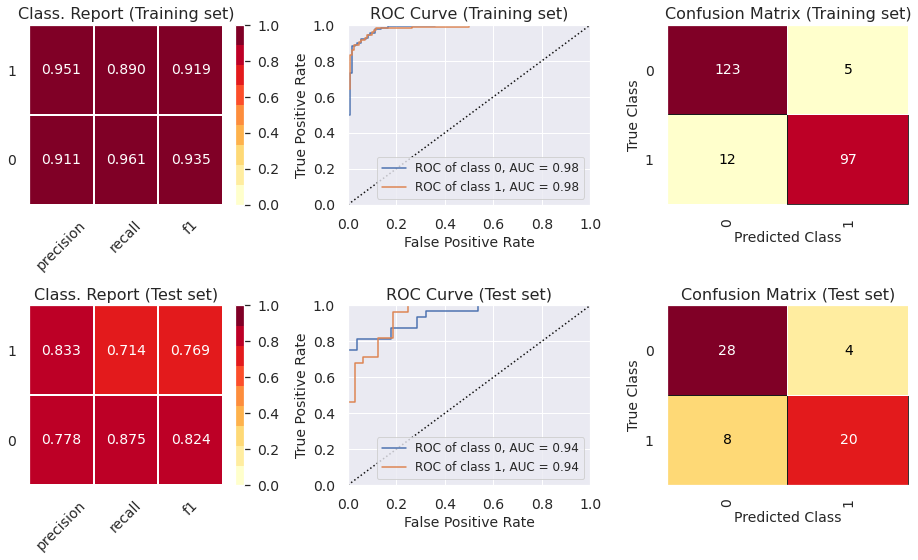

In [ ]:
# This line will disappear in the portfolio page
# Step 1: Set the size of the figure
plt.rcParams.update({'font.size': 14,'axes.titlesize': 16,'axes.labelsize': 14,'xtick.labelsize': 14,'ytick.labelsize': 14, 'legend.fontsize': 12})
fig, axes = plt.subplots(2,3, figsize=(13, 8))

# Step 2: Select the classifier (We need to fit it beforehand so that the visualizations work later on)
model = wrap(CatBoostClassifier(**best_parameters_model_6))
model.fit(X_train, y_train, eval_set = (X_train, y_train), verbose=0)

# Step 3: Create lists with the visualizers
visualizers_list_training = [ClassificationReport(model, classes=[0, 1], ax=axes[0,0], title = "Class. Report (Training set)"),
                    ROCAUC(model, classes=[0, 1], ax=axes[0,1], title = "ROC Curve (Training set)",micro=False, macro=False),
                    ConfusionMatrix(model, classes=[0, 1], ax=axes[0,2], title = "Confusion Matrix (Training set)")]

visualizers_list_test = [ClassificationReport(model, classes=[0, 1], ax=axes[1,0], title = "Class. Report (Test set)"),
                    ROCAUC(model, classes=[0, 1], ax=axes[1,1], title = "ROC Curve (Test set)",micro=False, macro=False),
                    ConfusionMatrix(model, classes=[0, 1], ax=axes[1,2], title = "Confusion Matrix (Test set)")]

# Step 4: Generate visualizations for the training set
for visualizer in visualizers_list_training:
  visualizer.fit(X_train, y_train)                                # Fit the training data to the visualizer
  visualizer.score(X_train, y_train)                              # Evaluate the model on the training data
  visualizer.finalize()

# Step 5: Generate visualizations for the test set
for visualizer in visualizers_list_test:
  visualizer.fit(X_train, y_train)                                # Fit the training data to the visualizer
  visualizer.score(X_test, y_test)                              # Evaluate the model on the test data
  visualizer.finalize()

- The ROC curve indicates that the classifiers outperform random classifier (the baselines).
- **The Decision Tree Classifier presents high levels of ovefitting**. The other models did not present levels of underfitting or overfitting that are enough to cause any concern. **In part 6, we show how to prevent overfitting using other cross-validation techniques.** 

## 6) Reduce overfitting using other cross-validation techniques

- We use **repeated stratified K-Fold as the cross-validation** strategy solely for the **decision tree classifier** to avoid overfitting. We did not use this strategy for other classifiers since they did not overfit using the k-fold strategy, which is a less time-consuming technique.

### 6.1) Hyperparameter tuning (random search + repeated stratified K-Fold cross validation)

In [ ]:
# This line will disappear in the portfolio page
# Step 1: Select the classifier
clf = DecisionTreeClassifier()

# Step 2: Select possible hyperparameters to be tested
parameters = {"splitter":["best","random"], "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10], "criterion" :["gini", "entropy", "log_loss"], "random_state" : [42],
                "min_weight_fraction_leaf":[0, 0.1,0.2,0.3,0.4,0.5],"min_impurity_decrease": [0.0] ,"class_weight":[None,'balanced'],
                "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90], 'min_samples_split': [1,2,3,4,5,6,7,8,9,10], "ccp_alpha": [0],"max_depth" : [2,3,4,5,6,7]}

# Step 3: Specify cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state = 42)

# Step 4: Determine the optimal hyperparameters to maximize the recall metrics
grid = RandomizedSearchCV(estimator = clf, param_distributions = parameters, scoring = 'recall', cv = cv, n_iter = 500, random_state=42)
grid.fit(X_train, y_train.ravel()) # We need to use .values.ravel() to avoid warning message
best_parameters_model_1 = grid.best_params_
print('Optimal hyperparameters: \n\n',best_parameters_model_1)

Optimal hyperparameters: 

 {'splitter': 'random', 'random_state': 42, 'min_weight_fraction_leaf': 0.1, 'min_samples_split': 4, 'min_samples_leaf': 3, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 80, 'max_depth': 4, 'criterion': 'entropy', 'class_weight': 'balanced', 'ccp_alpha': 0}


### 6.2) Evaluation of optimal model metrics

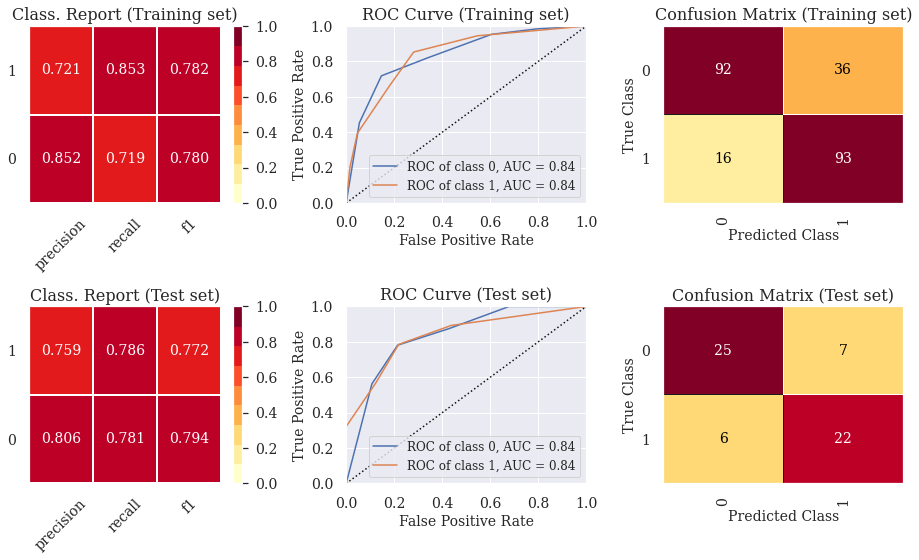

In [ ]:
# This line will disappear in the portfolio page
# Step 1: Set the size of the figure
plt.rcParams.update({'font.size': 14,'axes.titlesize': 16,'axes.labelsize': 14,'xtick.labelsize': 14,'ytick.labelsize': 14, 'legend.fontsize': 12})
fig, axes = plt.subplots(2,3, figsize=(13, 8))

# Step 2: Select the classifier
model = DecisionTreeClassifier(**best_parameters_model_1)

# Step 3: Create lists with the visualizers
visualizers_list_training = [ClassificationReport(model, classes=[0, 1], ax=axes[0,0], title = "Class. Report (Training set)"),
                    ROCAUC(model, classes=[0, 1], ax=axes[0,1], title = "ROC Curve (Training set)",micro=False, macro=False),
                    ConfusionMatrix(model, classes=[0, 1], ax=axes[0,2], title = "Confusion Matrix (Training set)")]

visualizers_list_test = [ClassificationReport(model, classes=[0, 1], ax=axes[1,0], title = "Class. Report (Test set)"),
                    ROCAUC(model, classes=[0, 1], ax=axes[1,1], title = "ROC Curve (Test set)",micro=False, macro=False),
                    ConfusionMatrix(model, classes=[0, 1], ax=axes[1,2], title = "Confusion Matrix (Test set)")]

# Step 4: Generate visualizations for the training set
for visualizer in visualizers_list_training:
  visualizer.fit(X_train, y_train)                                # Fit the training data to the visualizer
  visualizer.score(X_train, y_train)                              # Evaluate the model on the training data
  visualizer.finalize()

# Step 5: Generate visualizations for the test set
for visualizer in visualizers_list_test:
  visualizer.fit(X_train, y_train)                                # Fit the training data to the visualizer
  visualizer.score(X_test, y_test)                              # Evaluate the model on the test data
  visualizer.finalize()

**We can see that the overfitting issue was solved using repeated stratified K-Fold for cross validation**. 

## 7) Feature importance plots for the optimal models

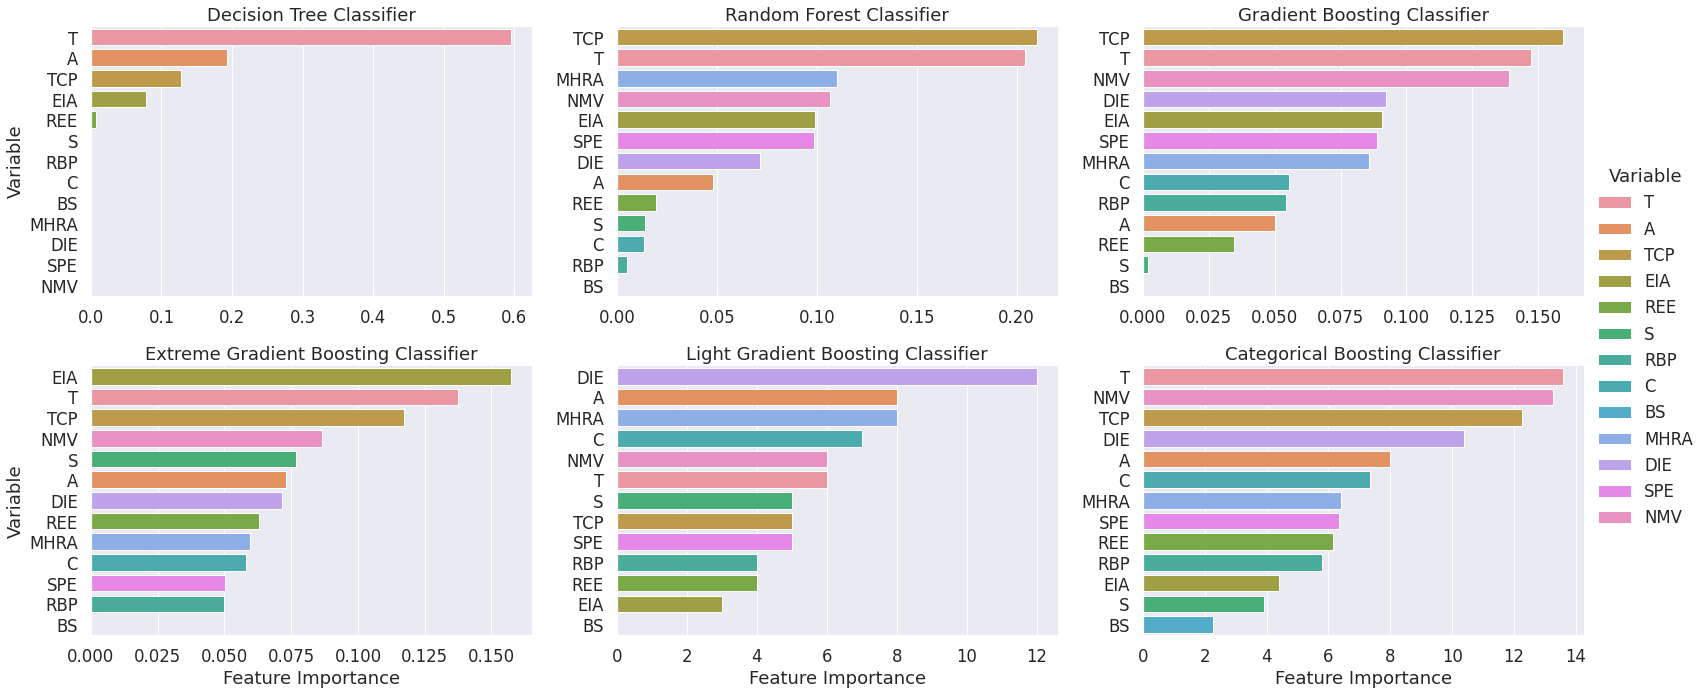

In [ ]:
# This line will disappear in the portfolio page
# Step 1: Select the classifier (We need to fit it beforehand so that the visualizations work later on)
model_1 = DecisionTreeClassifier(**best_parameters_model_1).fit(X_train, y_train)
model_2 = RandomForestClassifier(**best_parameters_model_2).fit(X_train, y_train)
model_3 = GradientBoostingClassifier(**best_parameters_model_3).fit(X_train, y_train)
model_4 = wrap(XGBClassifier(**best_parameters_model_4)).fit(X_train, y_train)
model_5 = wrap(lgb.LGBMClassifier(**best_parameters_model_5)).fit(X_train, y_train, eval_set = (X_train, y_train), verbose=0)
model_6 = wrap(CatBoostClassifier(**best_parameters_model_6)).fit(X_train, y_train, eval_set = (X_train, y_train), verbose=0)

dict_models = { 'Decision Tree Classifier': model_1, "Random Forest Classifier": model_2, "Gradient Boosting Classifier" : model_3,
                'Extreme Gradient Boosting Classifier': model_4, "Light Gradient Boosting Classifier": model_5, "Categorical Boosting Classifier" : model_6}

# Step 2: Create a dataframe with the feature importance for each model
list_df = []
for key, value in dict_models.items():
  feat_dict= {}
  for col, val in sorted(zip(X_train.columns, value.feature_importances_),key=lambda x:x[1],reverse=True):
    feat_dict[col]=val
  feat_df = pd.DataFrame({'Variable':feat_dict.keys(),'Feature Importance':feat_dict.values()})
  feat_df['Model'] = [key]*len(X_train.columns)
  list_df.append(feat_df)

# Step 3: Create a dataframe with the feature importance for all models
feature_importance_df = pd.concat(list_df)

# Step 4: Create a visualization for the feature importance of each model
sns.set(font_scale=1.5)
g = sns.catplot(x='Feature Importance', y='Variable', hue = 'Variable', col = 'Model', col_wrap=3, data=feature_importance_df,
            sharex=False, sharey=False, kind='bar',dodge=False, height=5, aspect=1.5)
g.set_titles(col_template='{col_name}')
plt.show()

- The visualization has a **consistent color scheme** across plots so that conclusions regarding the most relevant features can be drawn. 
- We can see that the **features "T", "TCP" and "NMV"** are often among the **most relevant predictors** of heart disease. 

## 8) Visualize decision trees (Help clients understand machine learning)

### 8.1) Visualization 1 - More complete visualization 

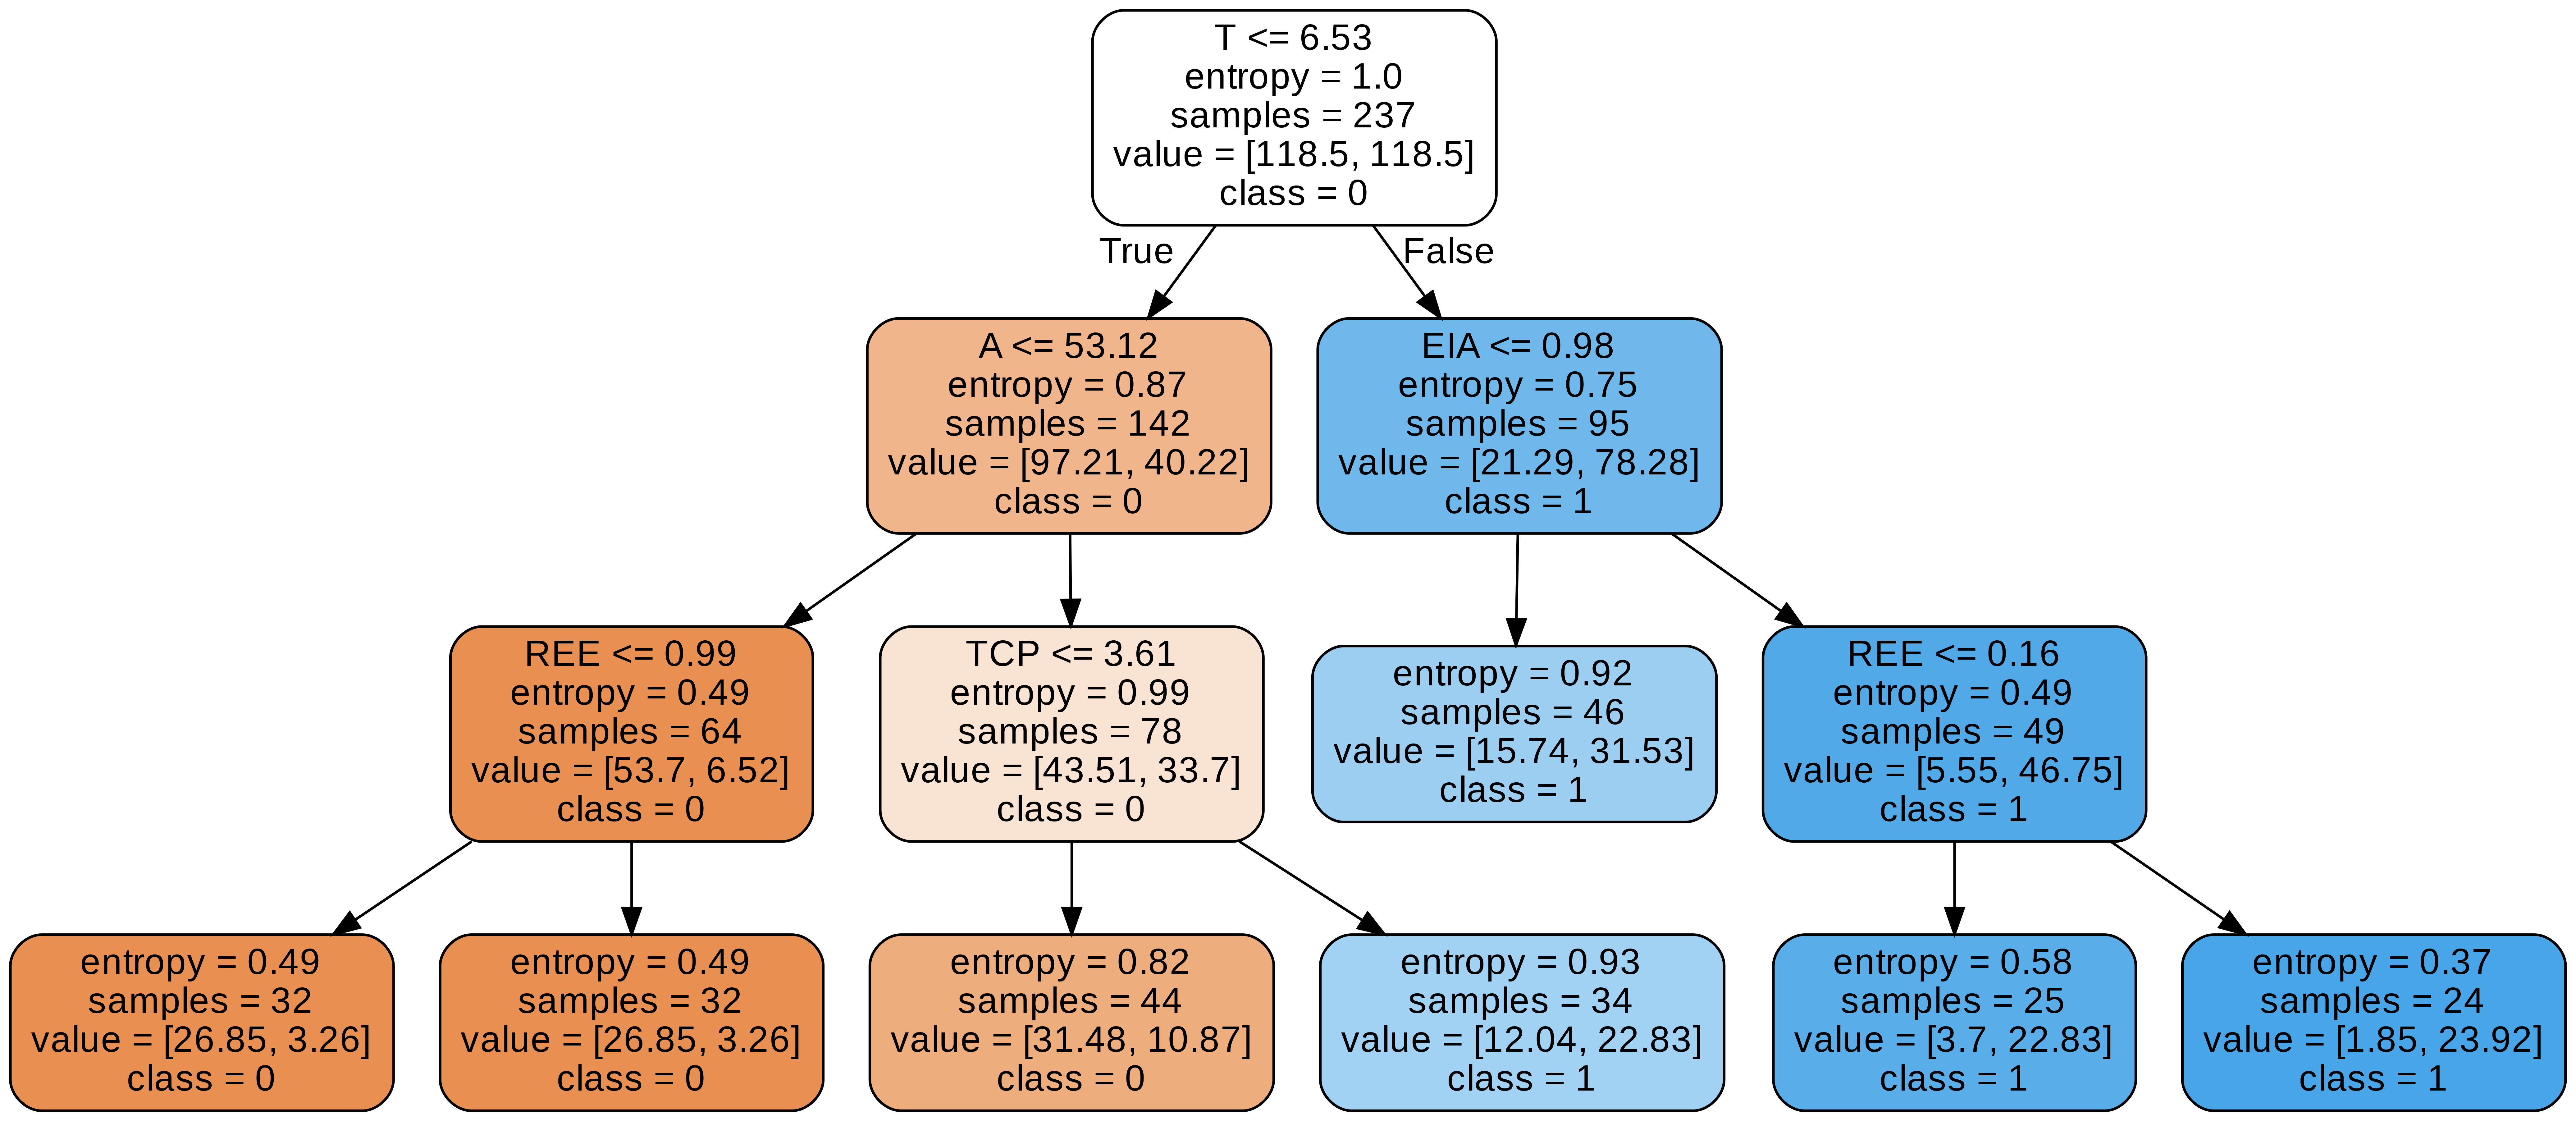

In [ ]:
# This line will disappear in the portfolio page
# Use export_graphviz to create an image that illustrates the decision tree classifier
export_graphviz(model_1, out_file='tree.dot',  feature_names = X_train.columns, class_names = ['0','1'],
                rounded = True, proportion = False, precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

Image(filename = 'tree.png')

### 8.2) Visualization 2 - Cleaner visualization

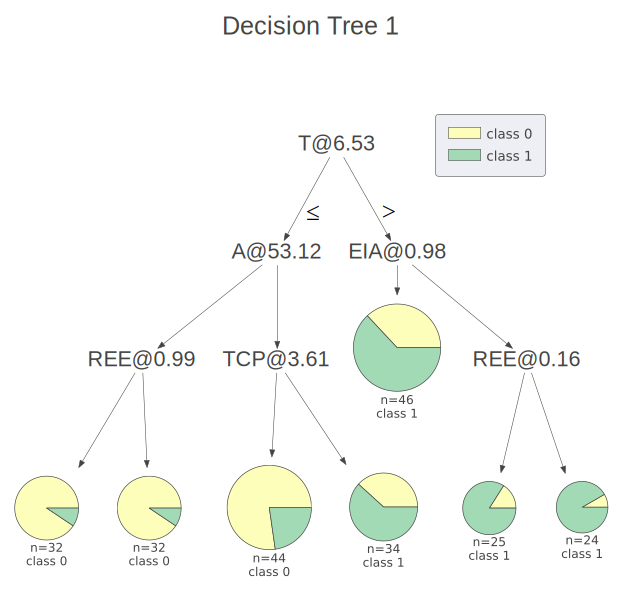

In [ ]:
dtreeviz(model_1, x_data=X_train, y_data=y_train, feature_names=X.columns, title="Decision Tree 1",fancy=False, scale=1.8)